In [1]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_decay import *

sim_name = f"no_gravity_decay"
#! marias files are inside the Data/decay folder
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

Gamma_str ='2T'

zeds_snaps = jnp.load(f"{sim_folder}/zeds_snaps.npy")
z_int_steps = jnp.load(f"{sim_folder}/z_int_steps.npy")
s_int_steps = jnp.load(f"{sim_folder}/s_int_steps.npy")
print(zeds_snaps[::-1][:10])
print(z_int_steps[0], z_int_steps[-1])

# note: We must have realistic neutrino masses
m_light, m_mid, m_heavy = Physics.neutrino_masses(
    m_lightest=0.05*Params.eV, ordering="NO", args=Params())
print(m_light, m_mid, m_heavy)

def find_nearest(array, value):
    idx = jnp.argmin(jnp.abs(array - value))
    return idx, array[idx]

[2.22044605e-16 7.00000000e-02 1.40000000e-01 2.10000000e-01
 2.90000000e-01 3.70000000e-01 4.60000000e-01 5.50000000e-01
 6.40000000e-01 7.40000000e-01]
0.0 3.9999999999999996
0.05 0.05073657457889723 0.07080960386840193


# Pre-sim arrays analysis

In [2]:
angle_momentum_decay = jnp.load(
    f'{sim_folder}/allowed_decay_angles_and_momenta.npy') 

decayed_neutrinos_z = jnp.load(
    f'{sim_folder}/decayed_neutrinos_z_{Gamma_str}.npy')
decayed_neutrinos_index_z = jnp.load(
    f'{sim_folder}/decayed_neutrinos_index_z_{Gamma_str}.npy', allow_pickle=True)
decayed_neutrinos_bin_z = jnp.load(
    f'{sim_folder}/decayed_neutrinos_bin_z_{Gamma_str}.npy')

z_array = jnp.load(
    f'{sim_folder}/z_int_steps.npy')
neutrino_momenta = jnp.load(
    f'{sim_folder}/neutrino_momenta.npy')

common_args = (
    angle_momentum_decay, decayed_neutrinos_z, z_array, neutrino_momenta,)

ic(angle_momentum_decay.shape)
ic(decayed_neutrinos_z.shape)
ic(decayed_neutrinos_index_z.shape)
ic(decayed_neutrinos_bin_z.shape)
ic(decayed_neutrinos_bin_z[0], decayed_neutrinos_bin_z[-1])
ic(z_array.shape)
ic(neutrino_momenta.shape)
print("END")

ic| angle_momentum_decay.shape: (1000, 1800, 2)
ic| decayed_neutrinos_z.shape: (105, 768000)
ic| decayed_neutrinos_index_z.shape: (105,)
ic| decayed_neutrinos_bin_z.shape: (105,)
ic| decayed_neutrinos_bin_z[0]: Array(0.07135255, dtype=float64)
    decayed_neutrinos_bin_z[-1]: Array(3.82115345, dtype=float64)
ic| z_array.shape: (100,)
ic| neutrino_momenta.shape: (1000,)


END


# Testing functionality inside simulation script

## jax.lax.cond with decay_tracker

In [ ]:
# If neutrino has decayed: Assign new velocity
def true_func(v_parent, decay_tracker):
    decay_tracker = decay_tracker.at[:].set(1)
    return v_parent, decay_tracker

# If neutrino has not decayed: Keep current velocity
def false_func(v_in, decay_tracker):
    return v_in, decay_tracker

# Example input values
pre_nu_number = jnp.array([1,1,0])
now_nu_number = jnp.array([1,0,0])
decay_tracker = jnp.zeros(3)
v_parent = jnp.array([1.0, 0.0, 0.0])
v_in = jnp.array([0.5, 0.5, 0.5])

for pre, now in zip(pre_nu_number, now_nu_number):

    # Get new/current velocity depending on decay condition being True/False
    v_out, decay_tracker = jax.lax.cond(
        (now == 0) & (pre == 1) & jnp.all(decay_tracker == 0),
        lambda _: true_func(v_parent, decay_tracker),
        lambda _: false_func(v_in, decay_tracker),
        operand=None
    )

    v_in = v_out

    print("v_out:", v_out)
    print("updated_decay_tracker:", decay_tracker)

In [ ]:
def test(v_parent, decay_tracker):
    decay_tracker = decay_tracker.at[:].set(v_parent)
    return v_parent, decay_tracker

decay_tracker = jnp.zeros(3)
v_parent = jnp.arange(3)
arrt = test(v_parent, decay_tracker)
print(arrt)

## Masking and valid indices arrays

In [ ]:
decay_angles = angle_momentum_decay[..., 0]
parent_momenta = angle_momentum_decay[..., 1]
print(decay_angles.shape, parent_momenta.shape)

p_index = 0
s_key = jnp.array([0, 0], dtype=jnp.uint32)

valid_mask = parent_momenta[p_index] > 0
valid_indices = jnp.arange(parent_momenta.shape[-1])
valid_indices = jnp.where(valid_mask, valid_indices, -1)
valid_indices = valid_indices[valid_indices != -1]
print(valid_indices.shape)

random_idx = jax.random.choice(s_key, valid_indices)
decay_theta = decay_angles[p_index, random_idx]
p_parent = parent_momenta[p_index, random_idx]

In [ ]:
def find_first_negative_indices(array):
    # Create a mask where the condition (array < 0) is True
    negative_mask = array < 0

    # Find the index of the first negative value in each row
    first_negative_indices = jnp.argmax(negative_mask, axis=-1)
    
    # If no negative values, set index to the last element in the row
    row_has_negative = jnp.any(negative_mask, axis=-1)
    first_negative_indices = jnp.where(row_has_negative, first_negative_indices, array.shape[1] - 1)
    
    return first_negative_indices

# Example usage
parent_momenta = jnp.array([[1.0, 0.5, -0.2, -0.5],
                            [2.0, 1.5, 1.0, 0.5],
                            [3.0, -1.0, -2.0, -3.0]])

indices = find_first_negative_indices(parent_momenta)
print(indices)

# Generating arrays (pre sim)

## Parent number density functions

For Gamma=0.1 x T_Universe, parent nr. density:
z_dec: 56.61 (56.61)
z_0: 5.01e-03 (5.01e-03)

For Gamma=0.5 x T_Universe, parent nr. density:
z_dec: 56.61 (56.61)
z_0: 8.76e+00 (8.76e+00)

For Gamma=1.0 x T_Universe, parent nr. density:
z_dec: 56.61 (56.61)
z_0: 2.23e+01 (2.23e+01)

For Gamma=2.0 x T_Universe, parent nr. density:
z_dec: 56.61 (56.61)
z_0: 3.55e+01 (3.55e+01)



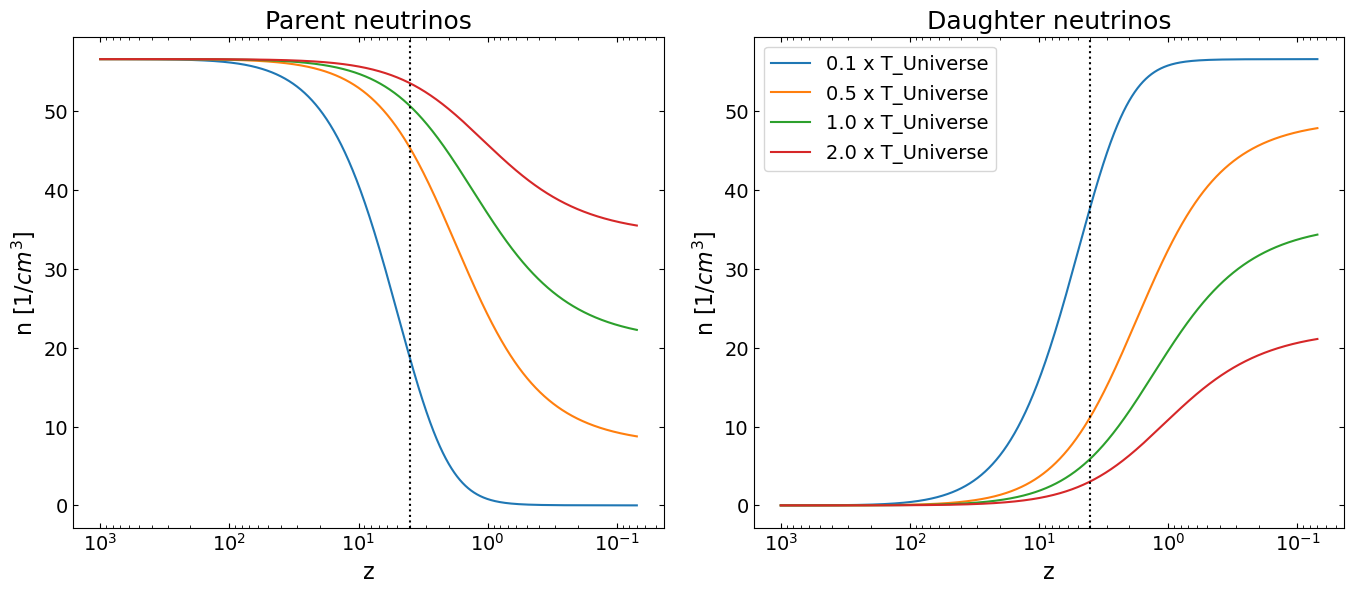

In [3]:
age_multipliers = [
    0.1, 
    0.5, 
    1., 
    2.
]

# Create momentum range
p_range = jnp.geomspace(0.01, 400, 1000)*Params.T_CNB

# Create redshift range
# note: this array determines the order of the pre-sim arrays
#! choose value high enough, that it saturates max n_nu
z_0, z_dec = 7e-2, 1000
z_range = jnp.logspace(jnp.log10(z_0), jnp.log10(z_dec), 5000)  # only for z_0 != 0
# z_range = Utils.make_logz_arr(z_0, z_dec, 5000)

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.tight_layout(pad=2.0)

decay_perc_l = []
for age_mult in age_multipliers:

    Gamma_val = 1/(age_mult*Params.t0)  # t0 = age of Universe

    ### New functions ###
    redshifted_p = p_range[:, None]*(1+z_range)

    n3_raw, *_ = Decay.n3_p_range(
        p=redshifted_p, z=z_range, 
        Gamma=Gamma_val, m_h=m_heavy, args=Params())
    # print(n3_raw.shape)
    n3_redshifts = trap(n3_raw*redshifted_p, x=jnp.log(redshifted_p), axis=0)

    # Print & plot results.
    cm3_unit = 1/Params.cm**3
    print(f"For Gamma={age_mult} x T_Universe, parent nr. density:")
    print(f"z_dec: {jnp.max(n3_redshifts)/cm3_unit:.2f} ({n3_redshifts[-1]/cm3_unit:.2f})")
    print(f"z_0: {jnp.min(n3_redshifts)/cm3_unit:.2e} ({n3_redshifts[0]/cm3_unit:.2e})\n")
    
    n3_decay_perc = ((n3_redshifts[-1] - n3_redshifts[0])/n3_redshifts[-1])*100
    decay_perc_l.append(n3_decay_perc)

    # Parents
    ax1.semilogx(
        z_range, n3_redshifts/cm3_unit,
        label=f"{age_mult} x T_Universe")
    ax1.set_title("Parent neutrinos")
    
    # Daughters
    n_decay_redshifts = n3_redshifts[-1] - n3_redshifts
    ax2.semilogx(
        z_range, n_decay_redshifts/cm3_unit,
        label=f"{age_mult} x T_Universe")
    ax2.set_title("Daughter neutrinos")


ax1.set_xlabel('z')
ax1.set_ylabel(r'n [$1/cm^3$]')

ax2.set_xlabel('z')
ax2.set_ylabel(r'n [$1/cm^3$]')

np.save(f"{sim_folder}/decayed_neutrinos_perc.npy", jnp.array(decay_perc_l))

ax1.axvline(4, color="black", ls="dotted")
ax2.axvline(4, color="black", ls="dotted")
# ax1.set_xlim(0,4)
# ax2.set_xlim(0,4)
ax1.invert_xaxis()
ax2.invert_xaxis()
plt.legend()
plt.show()

## Inverse sampling


Neutrinos that decayed since decoupling: 767931
occurences_redshifts limits:
0.07000000000000005 440.82807546143505
Histogram data: shape, sum, sum without first bin
(249,) 767931 767831
0.07000000000000005 964.2912238291523

Neutrinos that decayed since decoupling: 649205
occurences_redshifts limits:
0.07000000000000005 398.307491777846
Histogram data: shape, sum, sum without first bin
(249,) 649205 642096
0.07000000000000005 964.2912238291523

Neutrinos that decayed since decoupling: 465950
occurences_redshifts limits:
0.07000000000000005 206.20730076663523
Histogram data: shape, sum, sum without first bin
(249,) 465950 459245
0.07000000000000005 964.2912238291523

Neutrinos that decayed since decoupling: 286363
occurences_redshifts limits:
0.07000000000000005 89.3496722736216
Histogram data: shape, sum, sum without first bin
(249,) 286363 281841
0.07000000000000005 964.2912238291523


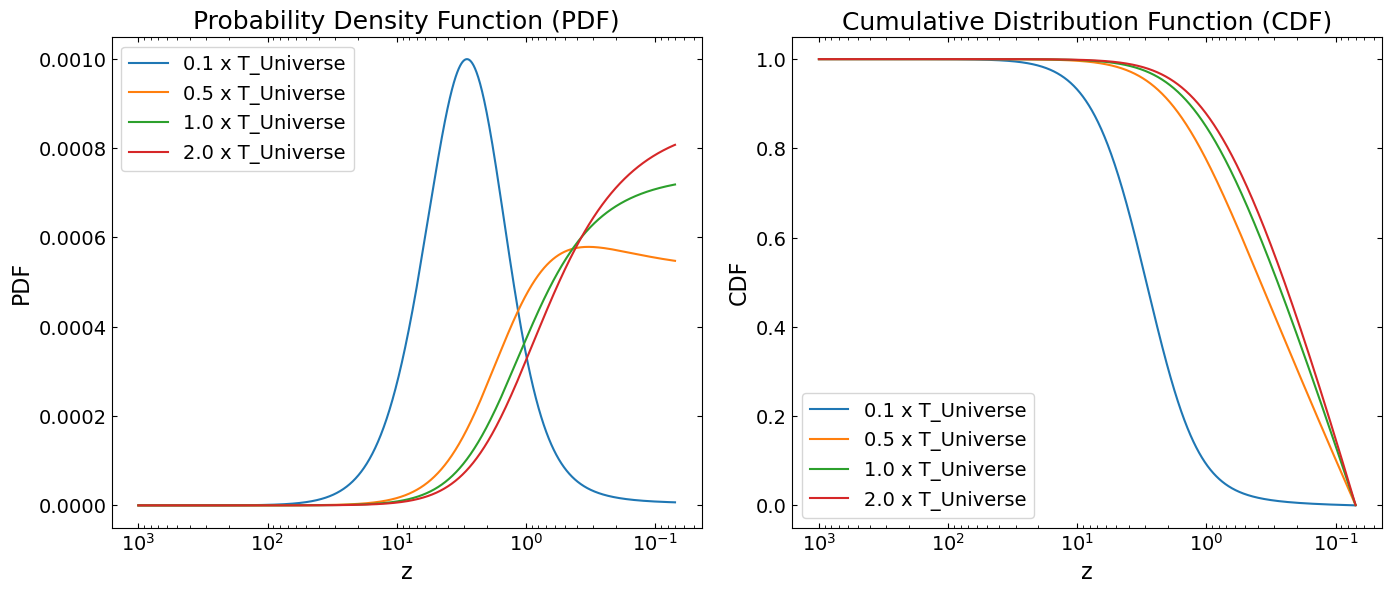

In [4]:
# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.tight_layout(pad=2.0)

histogram_data_l = []
bin_edges_data_l = []
decay_perc_data = np.load(f"{sim_folder}/decayed_neutrinos_perc.npy")
for age_mult, decay_perc in zip(age_multipliers, decay_perc_data):
    Gamma_val = 1 / (age_mult * Params.t0)  # t0 = age of Universe

    decayed_neutrinos = int(decay_perc / 100 * simdata.nus_in_sim)
    print("\nNeutrinos that decayed since decoupling:", decayed_neutrinos)

    # Inverse transform sampling
    pdf, cdf, occurences_redshifts = Decay.inverse_transform_sampling(
        z_range, p_range, m_heavy, decayed_neutrinos, Gamma_val, Params())
    print("occurences_redshifts limits:")
    print(occurences_redshifts.min(), occurences_redshifts.max())

    # Plot the PDF
    ax1.plot(z_range, pdf, label=f"{age_mult} x T_Universe")
    
    # Plot the CDF
    ax2.plot(z_range, cdf, label=f"{age_mult} x T_Universe")

    histogram_data, bin_edges = np.histogram(occurences_redshifts, bins=z_range[::20])

    print("Histogram data: shape, sum, sum without first bin")
    print(histogram_data.shape, histogram_data.sum(), histogram_data[1:].sum())
    print(bin_edges.min(), bin_edges.max())

    # Append bins centres (recall log spacing), and histogram counts
    bin_edges_data_l.append(np.sqrt(bin_edges[1:]*bin_edges[:-1]))
    histogram_data_l.append(histogram_data)


# Plot styling
ax1.set_title("Probability Density Function (PDF)")
ax1.set_xlabel("z")
ax1.set_ylabel("PDF")
ax1.set_xscale("log")
ax1.legend()

ax2.set_title("Cumulative Distribution Function (CDF)")
ax2.set_xlabel("z")
ax2.set_ylabel("CDF")
ax2.set_xscale("log")
ax2.legend()

ax1.invert_xaxis()
ax2.invert_xaxis()
plt.show(); plt.close()

(4, 249)
(4, 249)


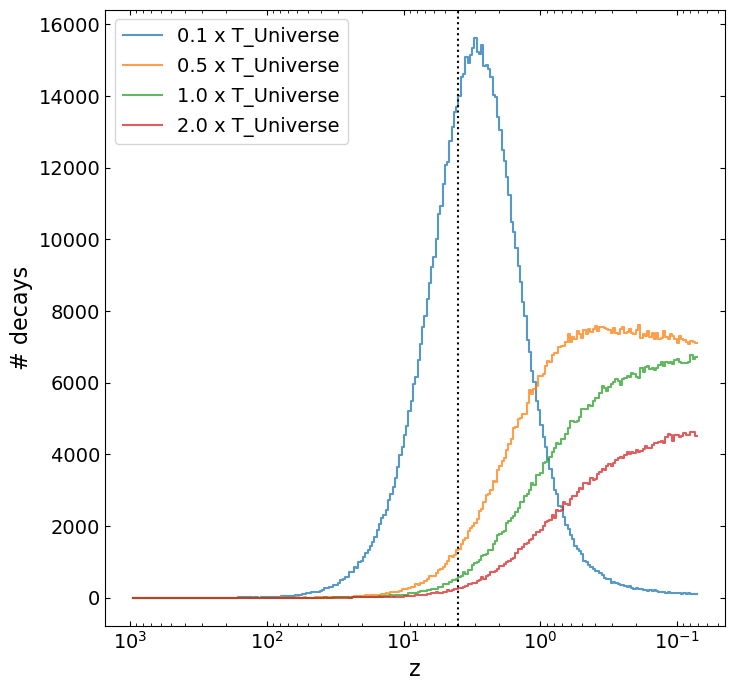

In [5]:
fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111)

# Plotting
for i, age_mult in enumerate(age_multipliers):
    ax.step(bin_edges_data_l[i], histogram_data_l[i], 
            where='post', alpha=0.75, label=f"{age_mult} x T_Universe")
#? think about correct where= keyword (pre, mid, post), and if it matters for sim

hist_jnp = jnp.array(histogram_data_l)
jnp.save(f"{sim_folder}/histogram_data.npy", hist_jnp)
print(hist_jnp.shape)

bins_jnp = jnp.array(bin_edges_data_l)
print(bins_jnp.shape)
jnp.save(f"{sim_folder}/bin_edges_data.npy", bins_jnp)

ax.axvline(4, color="black", ls="dotted")

ax.set_xlabel("z")
ax.set_xscale("log")
ax.set_ylabel("# decays")
ax.invert_xaxis()
plt.legend()
plt.show(); plt.close()

#? Are we taking relativistic time-delay into account?

The shape of the curves below 1e0 may create a bit of an illusion, that the populations are stabilizing, for the higher lifetimes. That's only because we plot it on a log scale, and we stop at redshift 0 (today). If we would somehow continue the curves into the future, then they would also decrease again until they reach zero.

## Generating pre-sim arrays

### Decay angles and momenta, as allowed by conservation laws

(10, 50, 2)
5 3.6032964613088203


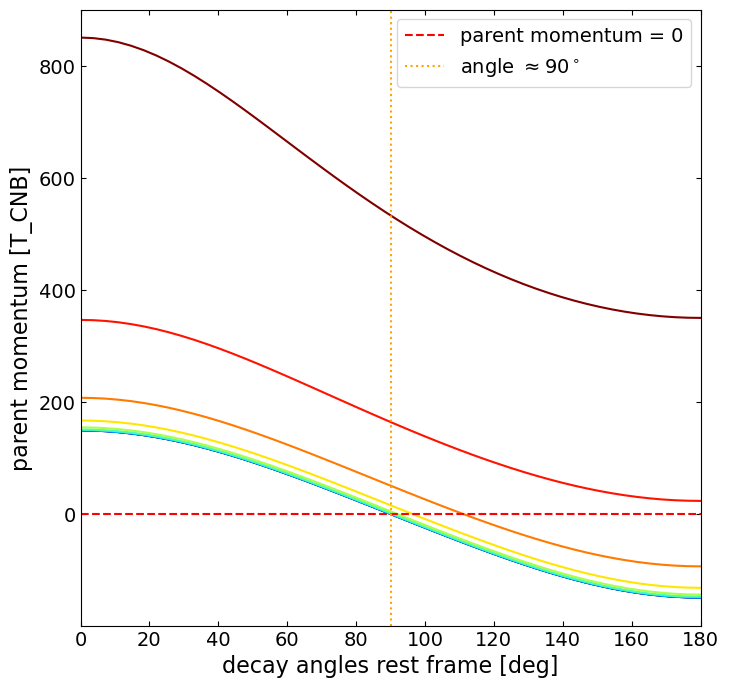

In [6]:
from scipy.optimize import fsolve
# note: Using numpy routines for fsolve compatibility


def rest_frame_quantities(m_h, m_l, m_phi):

    # Energies of daughter particles
    E_l = (m_h**2 + m_l**2 - m_phi**2) / (2*m_h)
    E_phi = (m_h**2 - m_l**2 + m_phi**2) / (2*m_h)

    # Momenta of daughter particles
    p_l = np.sqrt((m_h**2+m_l**2-m_phi**2)**2 - 4*m_h**2*m_l**2) / (2*m_h)
    p_phi = np.sqrt((m_h**2-m_l**2+m_phi**2)**2 - 4*m_h**2*m_phi**2) / (2*m_h)

    return E_l, p_l, E_phi, p_phi


# Rest frame (suscript 0) kinematics are completely fixed by masses
E_l_0, p_l_0, E_phi_0, p_phi_0 = rest_frame_quantities(m_h=m_heavy, m_l=m_light, m_phi=0.0)
# print(f"CHECK 1: ", np.isclose(p_l_0 - p_phi_0, [0.0]))
# print(f"CHECK 2: ", np.isclose(E_l_0 + E_phi_0, [m_heavy]))


def lab_frame_parent_momenta(p_h, p_l_z_target, angle, m_h, E_l_0, p_l_0):

    # Decay angle between axis of boost and p_l_0, i.e. momentum of daughter in rest frame
    # note: angle is defined via unit circle, so 0 deg is antiparallel,
    # note: we subtract pi, s.t. 0 deg corresponds to "straight line decay" in same direction
    cos_theta_0 = np.cos(np.deg2rad(angle) - np.pi)

    # Energy, velocity and Lorentz factor
    E_h = np.sqrt(p_h**2 + m_h**2)
    v_h = p_h/E_h
    gamma = 1/np.sqrt(1 - v_h**2)

    # Daughter momentum in lab frame
    p_l_z = gamma*(p_l_0*cos_theta_0 + v_h*E_l_0)

    # Return output as needed for fsolve to solve for it to become zero
    return p_l_z - p_l_z_target



common_args = (m_heavy, E_l_0, p_l_0)
p_num = 10  # target: p_num of sim = 1000 (or higher if needed, but base is 1k)
p_l_z_target_range = np.geomspace(0.01, 400, p_num)*Params.T_CNB
a_min = 0
a_max = 180
a_num = 50  # target: 1800
angles = np.linspace(a_min, a_max, a_num)

p_h_sol = np.empty((len(p_l_z_target_range), len(angles), 2))
for i, p_l_z_target in enumerate(p_l_z_target_range):
    
    for j, angle in enumerate(angles):
        p_h_fsolve = fsolve(
            func=lab_frame_parent_momenta, x0=p_l_z_target,
            args=(p_l_z_target, angle, *common_args))[0]
        
        #! If negative, decay angle is impossible with target daughter momentum
        # if p_h_fsolve < 0.0:
        #     p_h_fsolve = np.nan

        p_h_sol[i,j,0] = angle
        p_h_sol[i,j,1] = p_h_fsolve

print(p_h_sol.shape)
np.save(f"{sim_folder}/allowed_decay_angles_and_momenta_notebook.npy", p_h_sol)

p_l_select = 3.15*Params.T_CNB
idx, val = find_nearest(p_l_z_target_range, p_l_select)
print(idx, val/Params.T_CNB)


fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111)

colors = plt.cm.jet(np.linspace(0, 1, p_num))
for c, p_h_set in enumerate(p_h_sol):

    ax.plot(p_h_set[..., 0], p_h_set[..., 1]/Params.T_CNB, color=colors[c])


ax.axhline(0.0, color="red", ls='dashed', label="parent momentum = 0")
ax.axvline(90.0, color="orange", ls="dotted", label=r"angle $\approx 90^\circ$")
ax.set_xlabel(f"decay angles rest frame [deg]")
ax.set_ylabel(f"parent momentum [T_CNB]")
ax.set_xlim(a_min, a_max)  # normal
# ax.set_xlim(85, 95) ; ax.set_ylim(-0.5, 0.5)  # zoom-in
plt.legend(loc="upper right")
plt.show(); plt.close()

### Decay redshifts

In [ ]:
def generate_decay_redshifts(
        histogram_data, bin_edges_data, gamma_str, neutrinos, sim_folder):

    # Create an array representing individual neutrinos (all ones)
    neutrinos_array = np.ones(neutrinos)

    # Lists to store decayed information for each redshift step
    decayed_redshift = []
    neutrinos_decayed_index = []

    # Track remaining neutrino indices
    remaining_indices = np.arange(neutrinos)
    
    # Determine index corresponding to z_sim = 4
    z_sim = np.argwhere(bin_edges_data <= 4.).flatten()[-1]

    # Iterate over redshift steps
    for num_decayed in histogram_data[:z_sim]:
        
        # Randomly select neutrinos to decay without replacement
        selected_indices = np.random.choice(
            remaining_indices, size=num_decayed, replace=False)
                
        # Append and store values
        neutrinos_decayed_index.append(selected_indices)
        
        # Update neutrinos_array to reflect decayed neutrinos
        neutrinos_array[selected_indices] = 0
        decayed_redshift.append(neutrinos_array)

        # Remove selected indices from remaining indices
        remaining_indices = np.setdiff1d(remaining_indices, selected_indices)

    # One check if part of routine worked
    # print(len(remaining_indices))
    # print(neutrinos - histogram_data[:z_sim].sum())
    
    # Save the results
    neutrinos_decayed_index_array = np.array(neutrinos_decayed_index, dtype=object)
    np.save(f'{sim_folder}/decayed_neutrinos_index_z_{gamma_str}.npy', neutrinos_decayed_index_array)
    np.save(f'{sim_folder}/decayed_neutrinos_z_{gamma_str}.npy', decayed_redshift)
    np.save(f'{sim_folder}/decayed_neutrinos_bin_z_{gamma_str}.npy', bin_edges_data[:z_sim])

    # print(np.array(decayed_redshift).shape)


gamma_strings = [
    "0.1T",
    "0.5T",
    "1T",
    "2T",
]


hist_data_arr = np.load(f"{sim_folder}/histogram_data.npy").astype(int)
bins_data_arr = np.load(f"{sim_folder}/bin_edges_data.npy")
# print(hist_data_arr.shape, bins_data_arr.shape)
for hist_data, bins_data, g_str in zip(hist_data_arr, bins_data_arr, gamma_strings):

    generate_decay_redshifts(
        histogram_data=hist_data, bin_edges_data=bins_data, gamma_str=g_str, 
        neutrinos=simdata.nus_in_sim, sim_folder=sim_folder)


### Some other behaviour tests

In [ ]:
i_arr = np.load(f'{sim_folder}/decayed_neutrinos_index_z_{Gamma_str}.npy', allow_pickle=True)
setter = np.concatenate([arr for arr in i_arr if arr.size > 0])
print(setter.shape[0]+619391)

In [ ]:
gammas = np.array(["0.1T", "0.5T", "1T", "2T"])
for g in gammas:
    g_idx = np.argwhere(gammas == g).flatten()[0]
    # print(g_idx)
    decay_perc_data = np.load(f"{sim_folder}/decayed_neutrinos_perc.npy")
    decayed_neutrinos = int(decay_perc_data[g_idx] / 100 * simdata.nus_in_sim)
    print(decayed_neutrinos)

In [ ]:
tot_dens_no_decay = jnp.load(
    f"{sim_folder}/../no_gravity/total_densities.npy")
print(tot_dens_no_decay.shape)
# tot_dens_rest = tot_dens_no_decay - tot_dens_used
# tot_dens_l_rest.append(jnp.squeeze(tot_dens_rest))

# Testing and plotting number densities (post sim)

In [7]:
vec_pixel = jnp.load(f'{sim_folder}/vectors_halo1.npy')
vec_total = vec_pixel.reshape(-1,2,6)

parent_densities = jnp.load(
    f"{sim_folder}/total_densities_{Gamma_str}_parents.npy")
daughter_densities = jnp.load(
    f"{sim_folder}/total_densities_{Gamma_str}_daughter.npy")

print(parent_densities[:5])
print(daughter_densities[:5])
print((parent_densities+daughter_densities)[:5])

[[56.59817452 56.60432873 56.60716103 56.60837603 56.60885943 56.60903685
  56.60909658 56.60911491 56.60912    56.60912127 56.60912155 56.60912159
  56.60912159 56.60912158 56.60912156 56.60912154 56.60912152 56.60912149
  56.60912145 56.60912141 56.60912136 56.60912129 56.60912121 56.60912109
  56.60912098 56.60912083 56.60912065 56.60912042 56.60912014 56.6091198
  56.60911938 56.60911887 56.60911824 56.60911733 56.60911653 56.60911538
  56.60911396 56.60911223 56.6091101  56.6091075  56.60910431 56.6091004
  56.60909561 56.60908869 56.60908255 56.60907374 56.60906296 56.60904974
  56.60903356 56.60901374]]
[[4.80228124e-09 5.88939031e-09 7.22242532e-09 8.85704310e-09
  1.08614344e-08 1.33191733e-08 1.63327130e-08 2.00276915e-08
  2.45581404e-08 3.01128082e-08 3.69231188e-08 4.52726994e-08
  5.55092754e-08 6.80590091e-08 8.34442559e-08 1.02305236e-07
  1.25426638e-07 1.53770124e-07 1.88514356e-07 2.31103670e-07
  2.83308175e-07 3.47297046e-07 4.25728352e-07 5.42073380e-07
  6.396806